In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pgmpy
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from experiment_utils import prep_data, discretize_data

import os

print(os.getcwd())

raw_data = pd.read_csv('./data/carton_1.csv')
raw_data.info()

/home/ignacy/cmu/bnc-formal-verification/src/paper_experiment_fire
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         330 non-null    object 
 1   Reading ID   330 non-null    int64  
 2   Humidity     330 non-null    float64
 3   Temperature  330 non-null    float64
 4   MQ139        330 non-null    int64  
 5   TVOC         330 non-null    int64  
 6   eCO2         330 non-null    int64  
 7   Detector     330 non-null    object 
 8   Status       330 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 23.3+ KB


In [2]:
raw_data.head()

,Time,Reading ID,Humidity,Temperature,MQ139,TVOC,eCO2,Detector,Status
0,0:00:00,1,43.5,21.3,98,0,400,OFF,0
1,0:00:01,2,43.5,21.3,97,0,400,OFF,0
2,0:00:02,3,43.6,21.4,97,0,400,OFF,0
3,0:00:03,4,43.6,21.4,97,0,400,OFF,0
4,0:00:04,5,43.7,21.4,98,0,400,OFF,0


In [3]:
data = prep_data(raw_data)

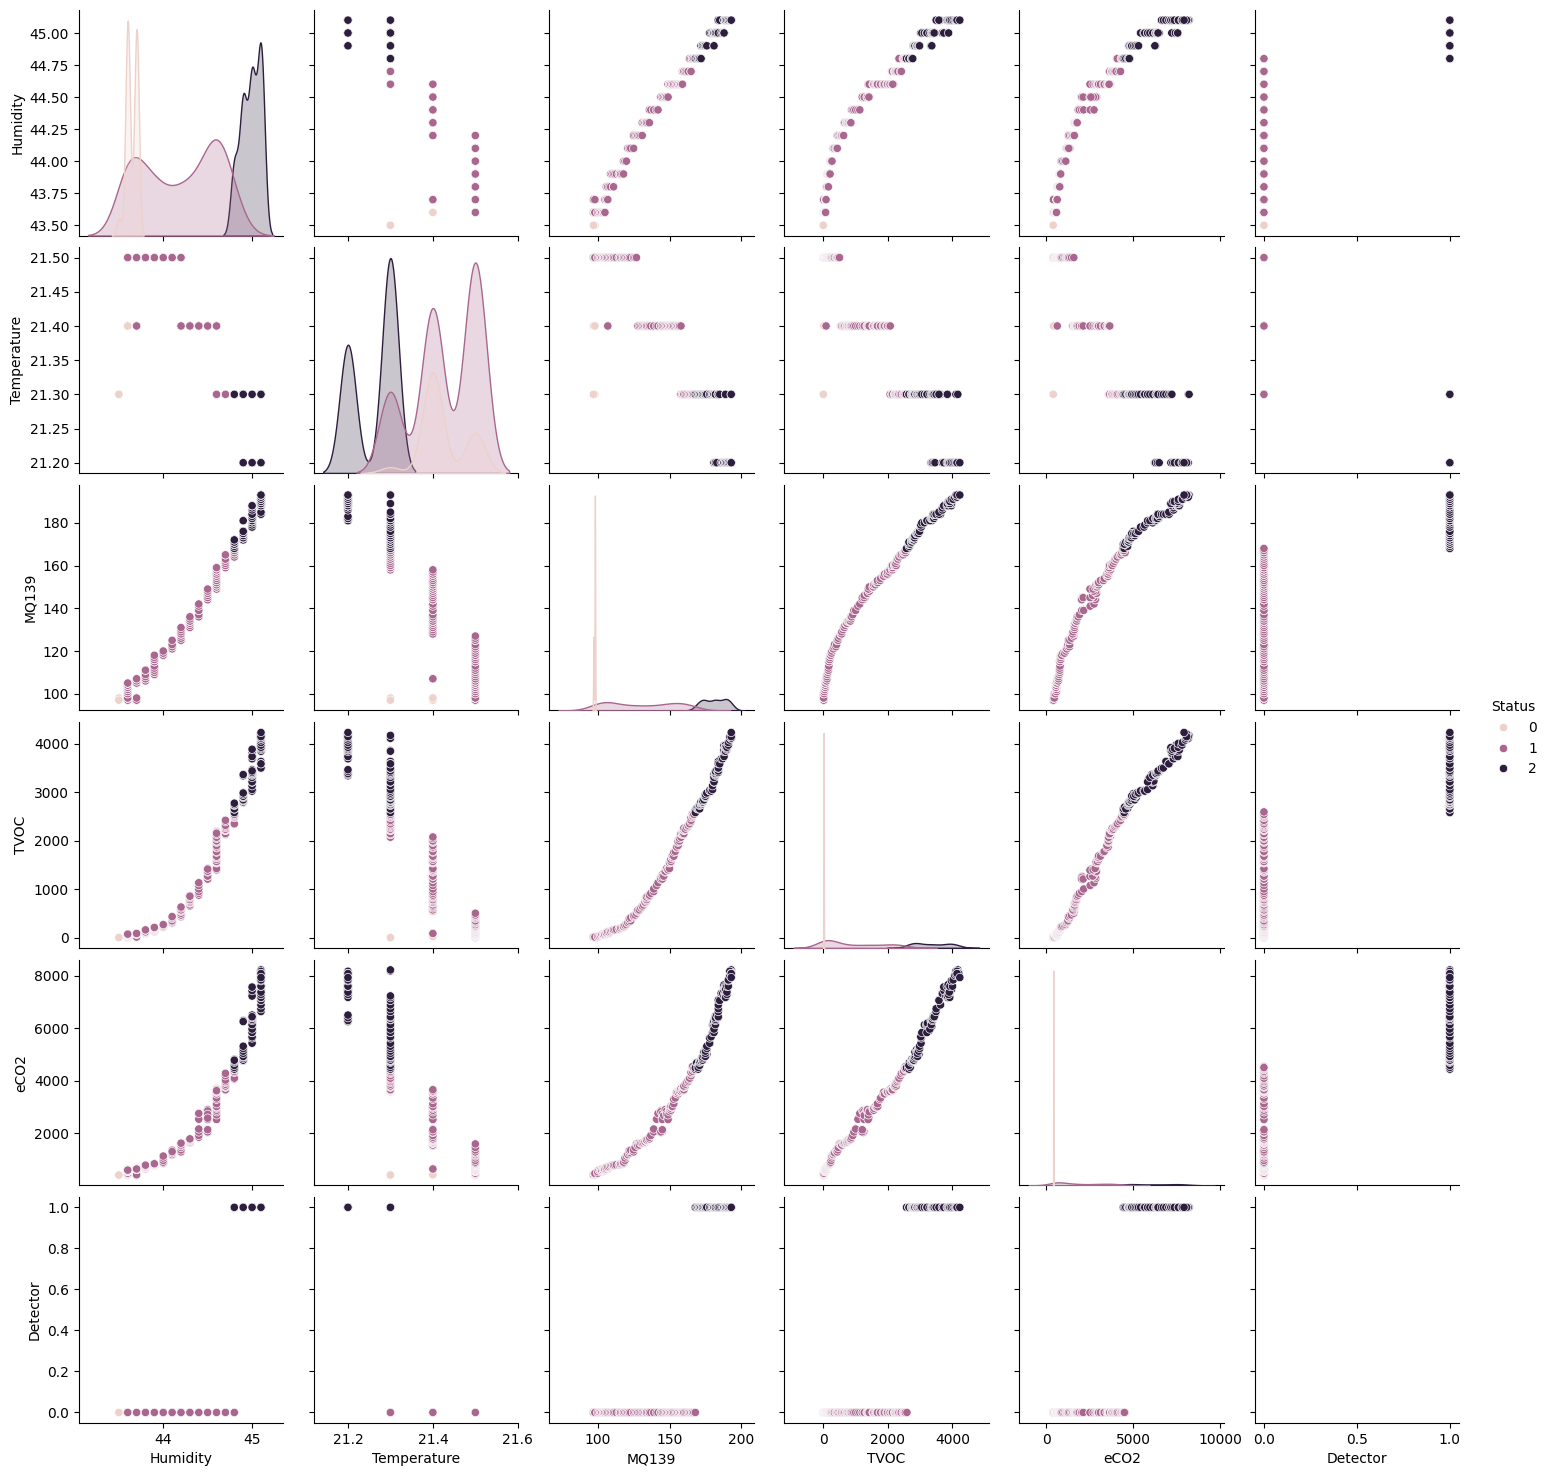

In [4]:
sns.pairplot(data, hue='Status')

In [6]:
data = discretize_data(data, data)

for column in data.columns:
    print(f'{column}: {data[column].unique().shape[0]}')

Humidity: 8
Temperature: 4
MQ139: 8
TVOC: 8
eCO2: 8
Detector: 2
Status: 3


### Infer the structure of Bayesian Network

In [7]:
from pgmpy.estimators import HillClimbSearch, TreeSearch, PC, ExhaustiveSearch, MmhcEstimator
import warnings

# Filter user warnings
warnings.filterwarnings('ignore')

models = []

hc = HillClimbSearch(data)
hc_best_model = hc.estimate()
models.append(hc_best_model)

print(f'Hill climb done')

ts = TreeSearch(data, root_node='Status')
ts_best_model = ts.estimate()
models.append(ts_best_model)

print(f'Tree search done')

pc = PC(data)
pc_best_model = pc.estimate(max_cond_vars=len(data.columns) - 2)
models.append(pc_best_model)

print(f'PC done')

mmhc = MmhcEstimator(data)
mmhc_best_model = mmhc.estimate()
models.append(mmhc_best_model)

print(f'MMHC done')


  0%|          | 0/1000000 [00:00<?, ?it/s]

Hill climb done


Building tree:   0%|          | 0/21.0 [00:00<?, ?it/s]

Tree search done


  0%|          | 0/5 [00:00<?, ?it/s]

PC done


  0%|          | 0/1000000 [00:00<?, ?it/s]

MMHC done


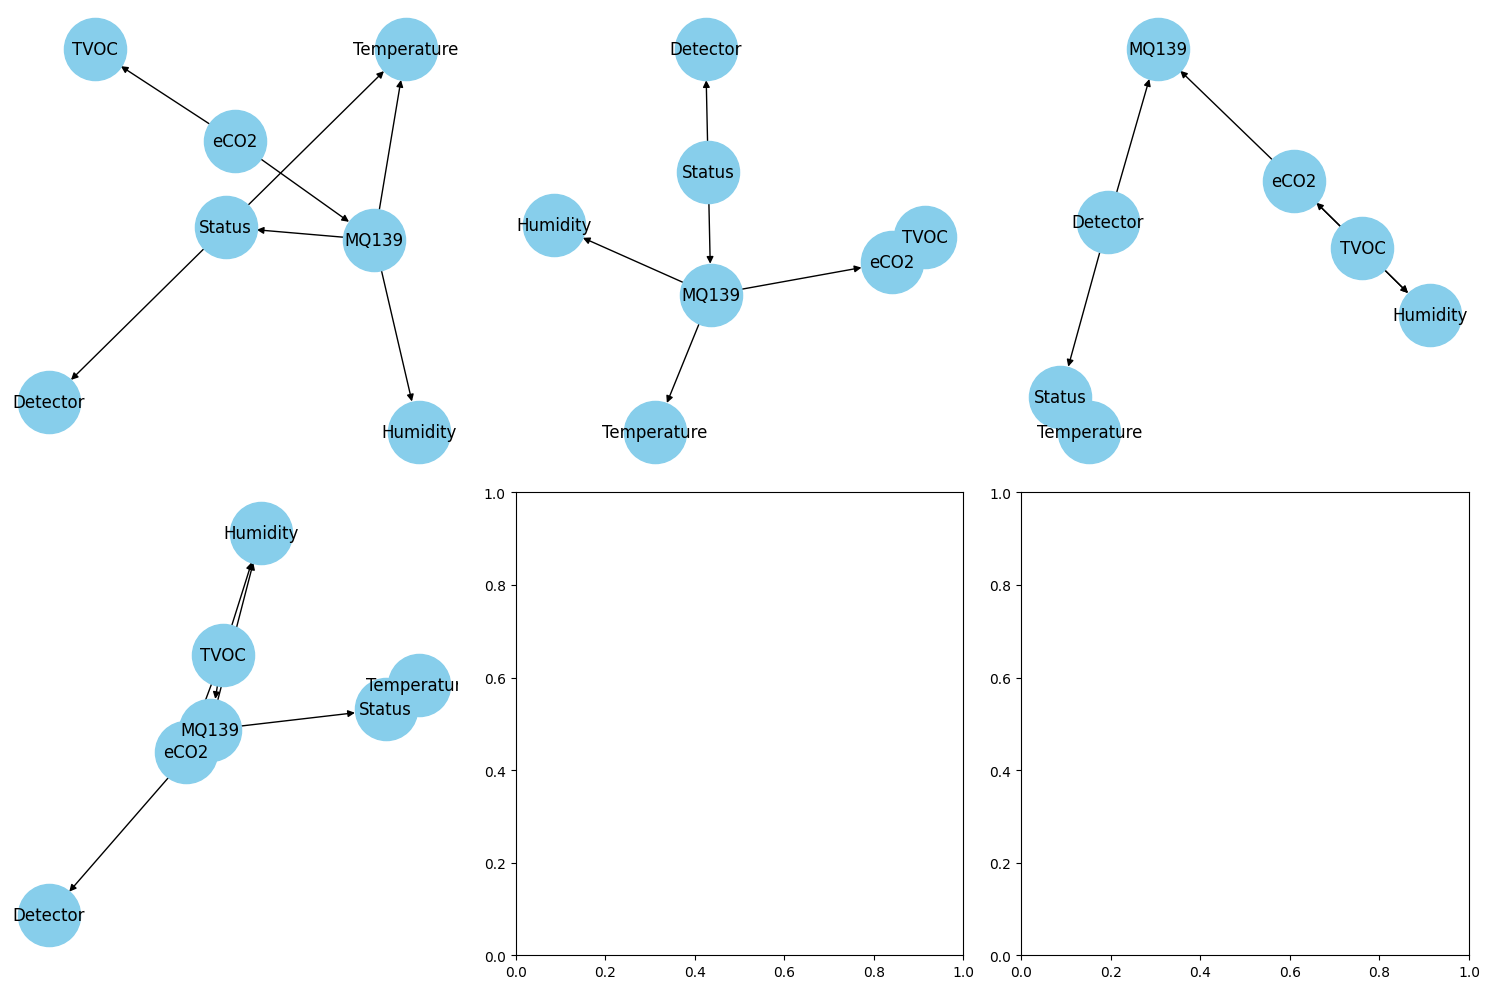

In [8]:
# Plot the model
import networkx as nx
import pylab as plt

# Set seed for reproducibility
# np.random.seed(7)

fig, ax = plt.subplots(len(models) // 2, len(models) // 2 + 1, figsize=(15, 10))
ax = ax.ravel()
for i, model in enumerate(models):
        G = nx.DiGraph()
        G.add_edges_from(model.edges())
        pos = nx.spring_layout(G)
        nx.draw(G, 
                pos, 
                with_labels=True,
                node_size=2000,
                node_color="skyblue",
                ax=ax[i]
                )
plt.tight_layout()
plt.show()

In [9]:
best_model = ts_best_model

### Estimate the parameters of Bayesian Network

In [10]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

# Learing CPDs using Maximum Likelihood Estimators
model = BayesianNetwork(best_model.edges())

model.fit(data, estimator=MaximumLikelihoodEstimator)

# Print CPD of the 'Status' variable
print(model.get_cpds('Status'))

+-----------+----------+
| Status(0) | 0.154545 |
+-----------+----------+
| Status(1) | 0.545455 |
+-----------+----------+
| Status(2) | 0.3      |
+-----------+----------+


### Check the accuracy of Bayesian Network on test data set

In [11]:
from sklearn.metrics import accuracy_score

# Predict the 'Status' variable on training data
y_pred = model.predict(data.drop('Status', axis='columns'))

acc = accuracy_score(data['Status'], y_pred['Status'])
print('Accuracy (on training data): ', acc)

  0%|          | 0/39 [00:00<?, ?it/s]

Accuracy (on training data):  0.8515151515151516


In [12]:
raw_data_carton_2 = pd.read_csv('./data/carton_2.csv')

data2 = prep_data(raw_data_carton_2)
data2 = discretize_data(data, data2)

data2.head()

,Humidity,Temperature,MQ139,TVOC,eCO2,Detector,Status
0,7.0,3.0,7.0,0.0,7.0,0,0
1,7.0,3.0,7.0,0.0,7.0,0,0
2,7.0,3.0,7.0,0.0,7.0,0,0
3,7.0,3.0,7.0,0.0,7.0,0,0
4,7.0,3.0,7.0,0.0,7.0,0,0


In [13]:
model.states

{'Status': [0, 1, 2],
 'MQ139': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
 'Detector': [0, 1],
 'Humidity': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
 'eCO2': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
 'Temperature': [0.0, 1.0, 2.0, 3.0],
 'TVOC': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]}

In [14]:
# Reorder columns of data2 to match data
data2 = data2[data.columns]


for col in data.columns:
    print(f'{col}: {data[col].unique()}')

Humidity: [0. 1. 2. 3. 4. 5. 6. 7.]
Temperature: [1. 2. 3. 0.]
MQ139: [0. 1. 2. 3. 4. 5. 6. 7.]
TVOC: [0. 1. 2. 3. 4. 5. 6. 7.]
eCO2: [0. 1. 2. 3. 4. 5. 6. 7.]
Detector: [0 1]
Status: [0 1 2]


In [15]:
# Check if all values from data2 are in data
for col in data.columns:
    print(f'{col}: {set(data2[col].unique()).issubset(data[col].unique())}')

Humidity: True
Temperature: True
MQ139: True
TVOC: True
eCO2: True
Detector: True
Status: True


In [16]:
data['TVOC'].unique()

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [17]:
X_test = data2.drop('Status', axis='columns')
# x_test = pd.DataFrame(
#     data=[[0., 0., 0., 0., 0., 0.]], 
#     columns = ['Humidity', 'MQ139', 'TVOC', 'eCO2', 'Temperature', 'Detector']
#     )

y_pred_carton_2 = model.predict(X_test)
y_pred_carton_2

  0%|          | 0/9 [00:00<?, ?it/s]

/home/ignacy/anaconda3/envs/cmu/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/home/ignacy/anaconda3/envs/cmu/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/home/ignacy/anaconda3/envs/cmu/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/home/ignacy/anaconda3/envs/cmu/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/home/ignacy/anaconda3/envs/cmu/lib/python3.10/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values

,Status
0,0
1,0
2,0
3,0
4,0
...,...
451,2
452,2
453,2
454,2


## RULES

In [18]:
from rulekit import RuleKit
from rulekit.classification import RuleClassifier
from sklearn.datasets import load_iris
 
RuleKit.init()
 
x, y = data.drop('Status', axis='columns').to_numpy(), data['Status'].to_numpy()
 
clf = RuleClassifier()
clf.fit(x, y)
prediction = clf.predict(x)
 
print(prediction)

Nov 09, 2023 9:18:25 PM com.rapidminer.tools.I18N <clinit>
INFO: Set locale to en.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.

In [19]:
# Extract the rules
rules = clf.model.rules

for rule in rules:
    r = rule.__str__()
    for i, attr in enumerate(data.drop('Status', axis='columns').columns):
        r = r.replace(f'att{i + 1}', attr)
        r = r.replace('-inf', '0')
        r = r.replace('inf', str(data[attr].max()))
    print(r)

IF Temperature = (0, 2.50) AND MQ139 = (0, 0.50) THEN label = {0}
IF MQ139 = (0, 0.50) THEN label = {0}
IF Detector = (0, 0.50) AND MQ139 = <0.50, 7.0) THEN label = {1}
IF Detector = (0, 0.50) THEN label = {1}
IF Detector = <0.50, 7.0) THEN label = {2}


## Decision Tree

In [116]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from math import floor

X_train = data.drop('Status', axis='columns')
y_train = data['Status']

X_test = data2.drop('Status', axis='columns')
y_test = data2['Status']

dt = DecisionTreeClassifier(criterion='entropy', splitter='random')
dt.fit(data.drop('Status', axis='columns'), data['Status'])

DecisionTreeClassifier(criterion='entropy', splitter='random')

In [117]:
train_accuracy = accuracy_score(y_train, dt.predict(X_train))
test_accuracy = accuracy_score(y_test, dt.predict(X_test))

print(f'Train accuracy: {train_accuracy:.3f}')
print(f'Test accuracy: {test_accuracy:.3f}')

Train accuracy: 0.952
Test accuracy: 0.798


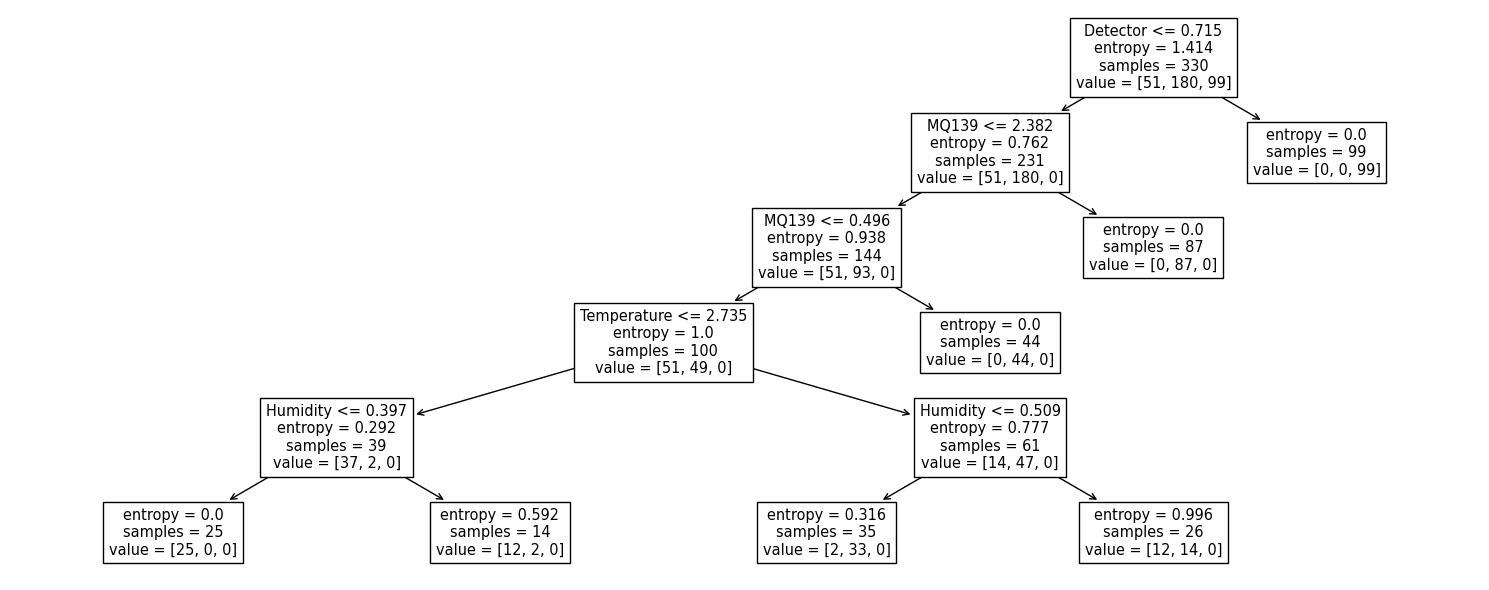

In [118]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_tree(dt, feature_names=data.drop('Status', axis='columns').columns.tolist(), ax=ax)
plt.tight_layout()
plt.show()

In [179]:
from extract_rules import extract_rules, add_coverage_to_rules, pretty_print, save_rules_to_json

X = X_train
y = y_train

# Get feature names (if available)
feature_names = X.columns.tolist()

# Get feature ranges (if available)
feature_ranges = {}
for feature in feature_names:
    feature_ranges[feature] = (X[feature].min(), X[feature].max())

# Extract rules for pure leaf nodes
rules = extract_rules(dt.tree_, 
                      feature_names, 
                    #   floor_threshold=False,
                    #   only_pure_leaves=False,
                      feature_ranges=feature_ranges)

rules = add_coverage_to_rules(rules, X)

for rule in rules:
    print(rule)

{'rule': [('Detector', '<=', 0.0), ('MQ139', '<=', 2.0), ('MQ139', '<=', 0.0), ('Temperature', '<=', 2.0), ('Humidity', '<=', 0.0)], 'class': 0, 'coverage': 0.076}
{'rule': [('Detector', '<=', 0.0), ('MQ139', '<=', 2.0), ('MQ139', '>', 0.0)], 'class': 1, 'coverage': 0.133}
{'rule': [('Detector', '<=', 0.0), ('MQ139', '>', 2.0)], 'class': 1, 'coverage': 0.264}
{'rule': [('Detector', '>', 0.0)], 'class': 2, 'coverage': 0.3}


In [180]:
pretty_print(rules, X, y)

------------------------------------------------------------
Rule: [('Detector', '<=', 0.0), ('MQ139', '<=', 2.0), ('MQ139', '<=', 0.0), ('Temperature', '<=', 2.0), ('Humidity', '<=', 0.0)]
Rule class: 0
0    25
Name: Status, dtype: int64
------------------------------------------------------------
Rule: [('Detector', '<=', 0.0), ('MQ139', '<=', 2.0), ('MQ139', '>', 0.0)]
Rule class: 1
1    44
Name: Status, dtype: int64
------------------------------------------------------------
Rule: [('Detector', '<=', 0.0), ('MQ139', '>', 2.0)]
Rule class: 1
1    87
Name: Status, dtype: int64
------------------------------------------------------------
Rule: [('Detector', '>', 0.0)]
Rule class: 2
2    99
Name: Status, dtype: int64


In [182]:
save_rules_to_json(rules, 'rules')

'rules.json'